In [1]:
import os
import json
import re
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
def read_json_file(filepath):
    """Reads and returns the contents of a JSON file."""
    with open(filepath, "r", encoding="utf-8") as f:
        return json.load(f)


def extract_metrics(data):
    """
    Extracts the desired metrics from the 'xquad_ro' section:
      - f1,none
      - f1_stderr,none
      - exact_match,none
      - exact_match_stderr,none
    """
    results = data.get("results", {}).get("xquad_ro", {})
    f1 = results.get("f1,none")
    f1_stderr = results.get("f1_stderr,none")
    exact_match = results.get("exact_match,none")
    exact_match_stderr = results.get("exact_match_stderr,none")
    return f1, f1_stderr, exact_match, exact_match_stderr


def extract_drop_count(folder_name, type):
    """
    Extracts the number of dropped blocks from the folder name.
    It searches for a pattern 'drop<number>' in the folder name.
    For example, '100-0shot_xquad_ro_RoLlama2-7b-Instruct_drop8_block.json'
    will extract the number 8.
    """
    match = None
    if type == "block":
        match = re.search(r"drop(\d+)_block", folder_name, re.IGNORECASE)
    elif type == "attn":    
        match = re.search(r"drop(\d+)_attn", folder_name, re.IGNORECASE)
    elif type == "mlp":
        match = re.search(r"drop(\d+)_mlp", folder_name, re.IGNORECASE)
    elif type == "all":
        match = re.search(r"drop(\d+)_all", folder_name, re.IGNORECASE)
    if match:
        return int(match.group(1))
    return None

In [3]:

def plot_importance_scores_layers(directory, model_name, type_drop, type_layer, dataset, calibration_samples):
    type_layer = "_" + type_layer if type_layer != "" else ""
    file_path = f"{directory}/{model_name}-{type_drop}_drop{type_layer}-{dataset}-{calibration_samples}samples.pt"
    tensor = torch.load(file_path, map_location=torch.device('cpu'))

    data = tensor.squeeze(-1).numpy()
    similarities = data[np.newaxis, :]
    importance_scores = 1 - similarities
    fig, ax = plt.subplots(figsize=(8, 1))
    ax = sns.heatmap(importance_scores, cmap="viridis_r")
    ax.set_xlabel("Block Index")
    ax.set_ylabel("Samples")
    ax.set_yticklabels(["32"])
    plt.savefig(f"{directory}/{model_name}-{type_drop}-{type_layer}_drop-{dataset}-{calibration_samples}samples.png")
    plt.show()



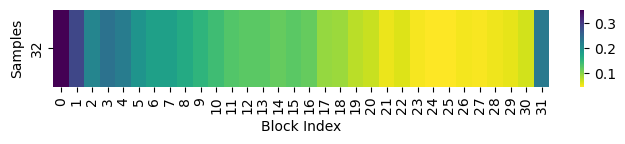

In [4]:
plot_importance_scores_layers("results_drop_similarities", "RoLlama2-7b-Instruct", "block", "", "saroco_val",  32)

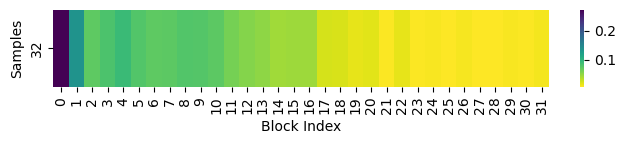

In [5]:
plot_importance_scores_layers("results_drop_similarities", "RoLlama2-7b-Instruct", "layer", "attn", "saroco_val",  32)

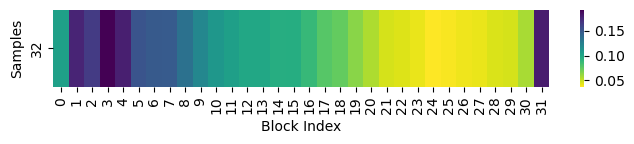

In [6]:
plot_importance_scores_layers("results_drop_similarities", "RoLlama2-7b-Instruct", "layer", "mlp", "saroco_val",  32)

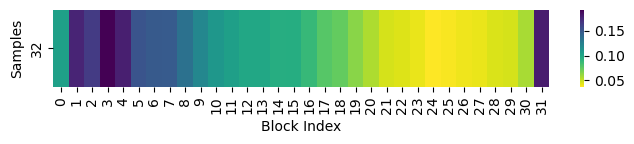

In [7]:
plot_importance_scores_layers("results_drop_similarities", "RoLlama2-7b-Instruct", "layer", "all_mlp", "saroco_val",  32)

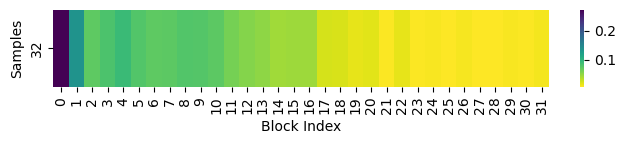

In [8]:
plot_importance_scores_layers("results_drop_similarities", "RoLlama2-7b-Instruct", "layer", "all_attn", "saroco_val",  32)

In [9]:

def plot_performance_task(directory, model_name, type_drop, task):

    script_dir = os.path.dirname(os.path.curdir)
    results_folder = os.path.join(script_dir, directory)

    data_list = []

    for subfolder in os.listdir(results_folder):
        subfolder_path = os.path.join(results_folder, subfolder)
        if os.path.isdir(subfolder_path):
            drop_count = extract_drop_count(subfolder, type_drop)
            if drop_count is None:
                print(
                    f"[INFO] The folder {subfolder} does not contain the 'drop' pattern. Skipping.")
                continue

            instruct_folder = os.path.join(
                subfolder_path, ".__RoLlama2-7b-Instruct")
            if not os.path.isdir(instruct_folder):
                print(
                    f"[INFO] The folder {subfolder_path} does not contain the '.__RoLlama2-7b-Instruct' subfolder. Skipping.")
                continue

            json_files = [f for f in os.listdir(
                instruct_folder) if f.endswith(".json")]
            if not json_files:
                print(
                    f"[INFO] No JSON file found in {instruct_folder}. Skipping.")
                continue

            json_filepath = os.path.join(instruct_folder, json_files[0])
            try:
                data = read_json_file(json_filepath)
                f1, f1_stderr, exact_match, exact_match_stderr = extract_metrics(
                    data)
                data_list.append((drop_count, f1, f1_stderr,
                                    exact_match, exact_match_stderr))
            except Exception as e:
                print(f"[ERROR] Reading file {json_filepath}: {e}")

    if not data_list:
        print("[INFO] No data found to generate plots.")
    else:
        data_list.sort(key=lambda x: x[0])
        drop_counts, f1_values, f1_stderr_values, exact_match_values, exact_match_stderr_values = zip(
            *data_list)
        return drop_counts, f1_values
        # plt.figure(figsize=(6, 4))
        # plt.plot(drop_counts, f1_values, marker='o')
        # # plt.errorbar(drop_counts, f1_values, yerr=f1_stderr_values, fmt='o')
        # plt.xlabel("Number of Dropped Modules")
        # plt.ylabel("F1 Score")
        # # plt.title(f"{model_name} - {type_drop} - {task}")
        # plt.grid()
        # plt.savefig(f"{directory}/{model_name}-{type_drop}-{task}.png")
        # plt.show()


[INFO] The folder 100-xquad_ro_RoLlama2-7b-Instruct_drop8_mlp.json does not contain the 'drop' pattern. Skipping.
[INFO] The folder 100-xquad_ro_RoLlama2-7b-Instruct_drop2_mlp.json does not contain the 'drop' pattern. Skipping.
[INFO] The folder 100-xquad_ro_RoLlama2-7b-Instruct_drop16_mlp.json does not contain the 'drop' pattern. Skipping.
[INFO] The folder 100-xquad_ro_RoLlama2-7b-Instruct_drop4_mlp.json does not contain the 'drop' pattern. Skipping.
[INFO] The folder 100-xquad_ro_RoLlama2-7b-Instruct_drop8_attn.json does not contain the 'drop' pattern. Skipping.
[INFO] The folder 100-xquad_ro_RoLlama2-7b-Instruct_drop16_attn.json does not contain the 'drop' pattern. Skipping.
[INFO] The folder 100-xquad_ro_RoLlama2-7b-Instruct_drop4_attn.json does not contain the 'drop' pattern. Skipping.
[INFO] The folder 100-xquad_ro_RoLlama2-7b-Instruct_drop2_attn.json does not contain the 'drop' pattern. Skipping.


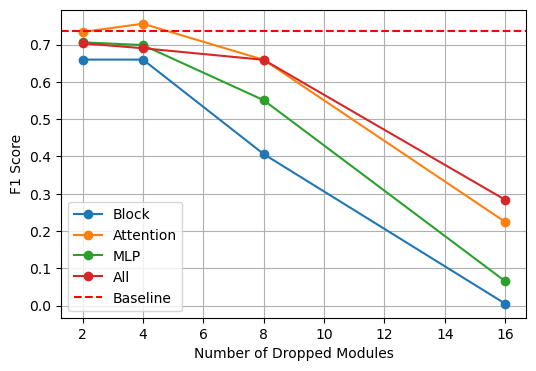

In [16]:
drop_count_block, f1_block = plot_performance_task("results_eval_xquad_ro_limit_100/block_drop", "RoLlama2-7b-Instruct", "block", "xquad_ro")
drop_count_attn, f1_attn = plot_performance_task("results_eval_xquad_ro_limit_100/layer_drop", "RoLlama2-7b-Instruct", "attn", "xquad_ro")
drop_count_mlp, f1_mlp = plot_performance_task("results_eval_xquad_ro_limit_100/layer_drop", "RoLlama2-7b-Instruct", "mlp", "xquad_ro")
drop_count_all, f1_all = plot_performance_task("results_eval_xquad_ro_limit_100/layer_drop_joint", "RoLlama2-7b-Instruct", "all", "xquad_ro")
baseline = 0.7357080142080145

# plot in the same graph
plt.figure(figsize=(6, 4))
plt.plot(drop_count_block, f1_block, marker='o', label="Block")
plt.plot(drop_count_attn, f1_attn, marker='o', label="Attention")
plt.plot(drop_count_mlp, f1_mlp, marker='o', label="MLP")
plt.plot(drop_count_all, f1_all, marker='o', label="All")
plt.axhline(y=baseline, color='r', linestyle='--', label="Baseline")
plt.xlabel("Number of Dropped Modules")
plt.ylabel("F1 Score")
plt.legend()
plt.grid()
plt.savefig("results_eval_xquad_ro_limit_100/RoLlama2-7b-Instruct-xquad_ro.png")
plt.show()

In [24]:
import os
import json

# List of JSONL files to compare
jsonl_files_block = []
jsonl_files_attn = []
jsonl_files_mlp = []
jsonl_files_all = []

# find all JSONL files in the directory
for root, dirs, files in os.walk("results_eval_xquad_ro_limit_100"):
    for file in files:
        if file.endswith(".jsonl"):
            path_file = os.path.join(root, file)
            if "block" in path_file:
                jsonl_files_block.append(path_file)
            elif "attn" in path_file:
                jsonl_files_attn.append(path_file)
            elif "mlp" in path_file:
                jsonl_files_mlp.append(path_file)
            elif "all" in path_file:
                jsonl_files_all.append(path_file)
    

print(jsonl_files_block)
print(jsonl_files_attn)
print(jsonl_files_mlp)
print(jsonl_files_all)

def read_jsonl(file_path):
    """Reads a JSONL file and returns its content as a list of dictionaries."""
    if not os.path.exists(file_path):
        print(f"[ERROR] File not found: {file_path}")
        return []

    try:
        with open(file_path, "r", encoding="utf-8") as f:
            return [json.loads(line) for line in f]
    except Exception as e:
        print(f"[ERROR] Could not read {file_path}: {e}")
        return []


def find_first_10_mismatches(data_sets, jsonl_files):
    """Finds and prints the first 10 mismatched answers across multiple JSONL files."""
    min_length = min(len(dataset) for dataset in data_sets)
    mismatches = []

    for i in range(min_length):

        answers = [dataset[i].get("filtered_resps", ["N/A"])[0]
                   for dataset in data_sets]

        if len(set(answers)) > 1:
            mismatches.append(
                (i, data_sets[0][i]['doc']['question'], data_sets[0][i]['doc']['context'][:300], answers))
            if len(mismatches) == 10:
                break

    if mismatches:
        print(f"\n[INFO] Found {len(mismatches)} mismatches:")
        for idx, (index, question, context, answers) in enumerate(mismatches):
            print(f"\n[MISMATCH {idx+1}] Index: {index}")
            print(f"Question: {question}")
            print(f"Context: {context}...")

            for file_idx, file in enumerate(jsonl_files):
                print(f"[{file}] Answer: {answers[file_idx]}")

    else:
        print("\n[INFO] No mismatches found across the provided files.")



['results_eval_xquad_ro_limit_100/block_drop/100-0shot_xquad_ro_RoLlama2-7b-Instruct_drop16_block.json/.__RoLlama2-7b-Instruct/samples_xquad_ro_2025-02-16T20-34-28.959166.jsonl', 'results_eval_xquad_ro_limit_100/block_drop/100-0shot_xquad_ro_RoLlama2-7b-Instruct_drop4_block.json/.__RoLlama2-7b-Instruct/samples_xquad_ro_2025-02-16T20-58-00.834823.jsonl', 'results_eval_xquad_ro_limit_100/block_drop/100-0shot_xquad_ro_RoLlama2-7b-Instruct_drop2_block.json/.__RoLlama2-7b-Instruct/samples_xquad_ro_2025-02-19T21-05-44.836454.jsonl', 'results_eval_xquad_ro_limit_100/block_drop/100-0shot_xquad_ro_RoLlama2-7b-Instruct_drop8_block.json/.__RoLlama2-7b-Instruct/samples_xquad_ro_2025-02-16T19-42-37.219450.jsonl']
['results_eval_xquad_ro_limit_100/layer_drop/100-xquad_ro_RoLlama2-7b-Instruct_drop8_attn.json/.__RoLlama2-7b-Instruct/samples_xquad_ro_2025-02-19T22-55-41.215078.jsonl', 'results_eval_xquad_ro_limit_100/layer_drop/100-xquad_ro_RoLlama2-7b-Instruct_drop16_attn.json/.__RoLlama2-7b-Instruct/

In [27]:
data_sets = [read_jsonl(file) for file in jsonl_files_attn]
find_first_10_mismatches(data_sets, jsonl_files_attn)




[INFO] Found 10 mismatches:

[MISMATCH 1] Index: 0
Question: Câte puncte a cedat apărarea echipei Panthers?
Context: Apărarea Panthers a cedat doar 308 puncte, clasându-se pe locul șase din ligă, în timp ce au dominat NFL la interceptări, în număr de 24 și s-au putut lăuda cu patru selecții la Pro Bowl. Jucătorul principal al apărării la Pro Bowl, Kawann Short, a condus echipa la numărul de sack-uri cu 11, forțând...
[results_eval_xquad_ro_limit_100/layer_drop/100-xquad_ro_RoLlama2-7b-Instruct_drop8_attn.json/.__RoLlama2-7b-Instruct/samples_xquad_ro_2025-02-19T22-55-41.215078.jsonl] Answer: 308
[results_eval_xquad_ro_limit_100/layer_drop/100-xquad_ro_RoLlama2-7b-Instruct_drop16_attn.json/.__RoLlama2-7b-Instruct/samples_xquad_ro_2025-02-19T23-13-58.955565.jsonl] Answer: 308.
[results_eval_xquad_ro_limit_100/layer_drop/100-xquad_ro_RoLlama2-7b-Instruct_drop4_attn.json/.__RoLlama2-7b-Instruct/samples_xquad_ro_2025-02-19T22-30-39.151219.jsonl] Answer: 308
[results_eval_xquad_ro_limit_100/